# Import required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import  make_scorer, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Reading dataset into a Pandas dataframe

In [ ]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Data exploration and analysis

Checking for any missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Checking for any outliers

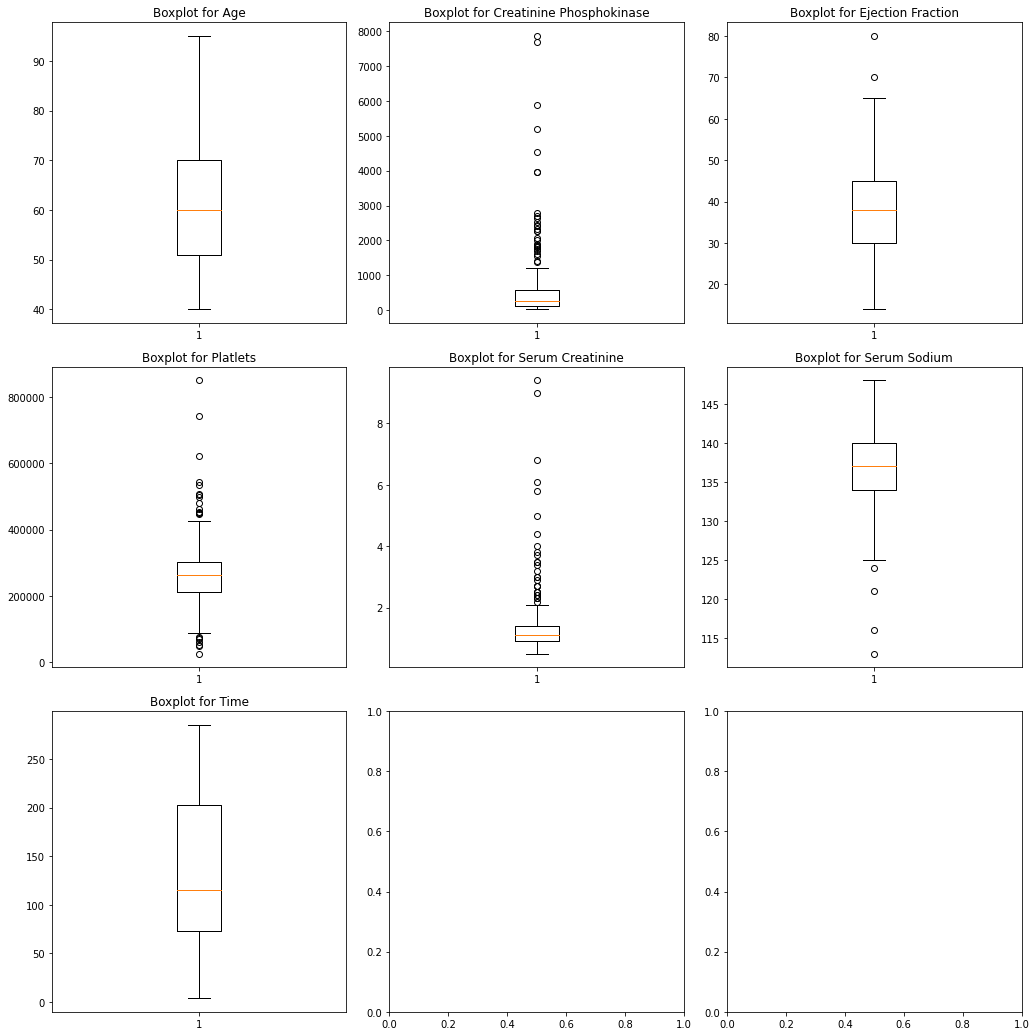

In [ ]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(14.5,14.5)
axs[0, 0].boxplot(df['age'])
axs[0, 0].set_title('Boxplot for Age')
axs[0, 1].boxplot(df['creatinine_phosphokinase'])
axs[0, 1].set_title('Boxplot for Creatinine Phosphokinase')
axs[0, 2].boxplot(df['ejection_fraction'])
axs[0, 2].set_title('Boxplot for Ejection Fraction')
axs[1, 0].boxplot(df['platelets'])
axs[1, 0].set_title('Boxplot for Platlets')
axs[1, 1].boxplot(df['serum_creatinine'])
axs[1, 1].set_title('Boxplot for Serum Creatinine')
axs[1, 2].boxplot(df['serum_sodium'])
axs[1, 2].set_title('Boxplot for Serum Sodium')
axs[2, 0].boxplot(df['time'])
axs[2, 0].set_title('Boxplot for Time')
fig.tight_layout()

plt.show()

Plot Correlation matrix to analyze the correlation between features

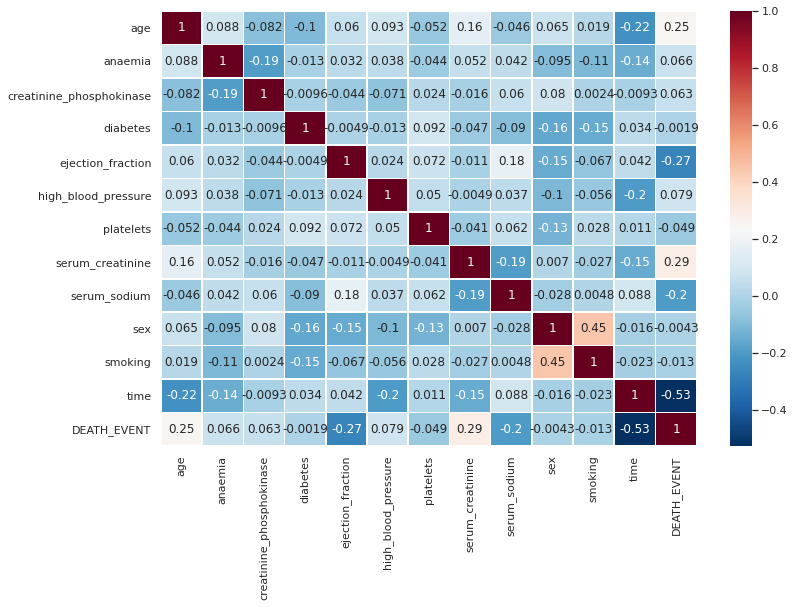

In [ ]:
corr = df.corr(method='pearson')

sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns,cmap='RdBu_r', annot=True, linewidth=0.5)

Normalize the dataset  using Robust Scaler

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [ ]:
scaler = RobustScaler().fit(X)
X_new = scaler.transform(X)
X_new

array([[ 0.78947368,  0.        ,  0.7132116 , ...,  0.        ,
         0.        , -0.85384615],
       [-0.26315789,  0.        , 16.35016112, ...,  0.        ,
         0.        , -0.83846154],
       [ 0.26315789,  0.        , -0.22341568, ...,  0.        ,
         1.        , -0.83076923],
       ...,
       [-0.78947368,  0.        ,  3.88829216, ..., -1.        ,
         0.        ,  1.25384615],
       [-0.78947368,  0.        ,  4.64661654, ...,  0.        ,
         1.        ,  1.26923077],
       [-0.52631579,  0.        , -0.1160043 , ...,  0.        ,
         1.        ,  1.30769231]])

# Modeling the data

Simple 80/20 splitting where 80% is training set and remaining 20% is testing set

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=.20, random_state=42)

Define the evaluation metrics for classification model

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

## Logistic Regression

In [ ]:
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True )
model =  LogisticRegression(C=0.7, max_iter=200, penalty='l2', solver='liblinear')
 
result = cross_validate(model , X_new, y, cv = kf, scoring=scoring)
 
result = pd.DataFrame(result)
result.mean()

fit_time          0.001748
score_time        0.003660
test_accuracy     0.819655
test_precision    0.754293
test_recall       0.665281
test_f1_score     0.683246
dtype: float64

## Support Vector Machine 

In [ ]:
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True )
model =  SVC()
 
result_svc = cross_validate(model , X_new, y, cv = kf, scoring=scoring)
 
result_svc = pd.DataFrame(result_svc)
result_svc.mean()

fit_time          0.003456
score_time        0.003886
test_accuracy     0.786437
test_precision    0.699610
test_recall       0.627375
test_f1_score     0.638337
dtype: float64

## XGBoost

In [ ]:
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True )
model =  xgb.XGBClassifier()
 
result_xgb = cross_validate(model , X_new, y, cv = kf, scoring=scoring)
 
result_xgb = pd.DataFrame(result_xgb)
result_xgb = result_xgb.append(result_xgb.mean(), ignore_index=True)
result_xgb

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,0.057525,0.003609,0.700000,0.714286,0.416667,0.526316
1,0.032853,0.003577,0.800000,0.888889,0.615385,0.727273
2,0.031032,0.003426,0.833333,0.888889,0.666667,0.761905
3,0.034265,0.005038,0.866667,1.000000,0.692308,0.818182
4,0.025268,0.002586,0.700000,0.333333,0.800000,0.470588
5,0.035263,0.003463,0.933333,0.888889,0.888889,0.888889
6,0.031668,0.004097,0.900000,0.857143,0.750000,0.800000
7,0.033112,0.003534,0.833333,0.625000,0.714286,0.666667
8,0.034569,0.005415,0.833333,0.818182,0.750000,0.782609
9,0.033722,0.003573,0.965517,0.833333,1.000000,0.909091


In [ ]:
model.fit(x_train,y_train)
pred = model.predict(x_test)

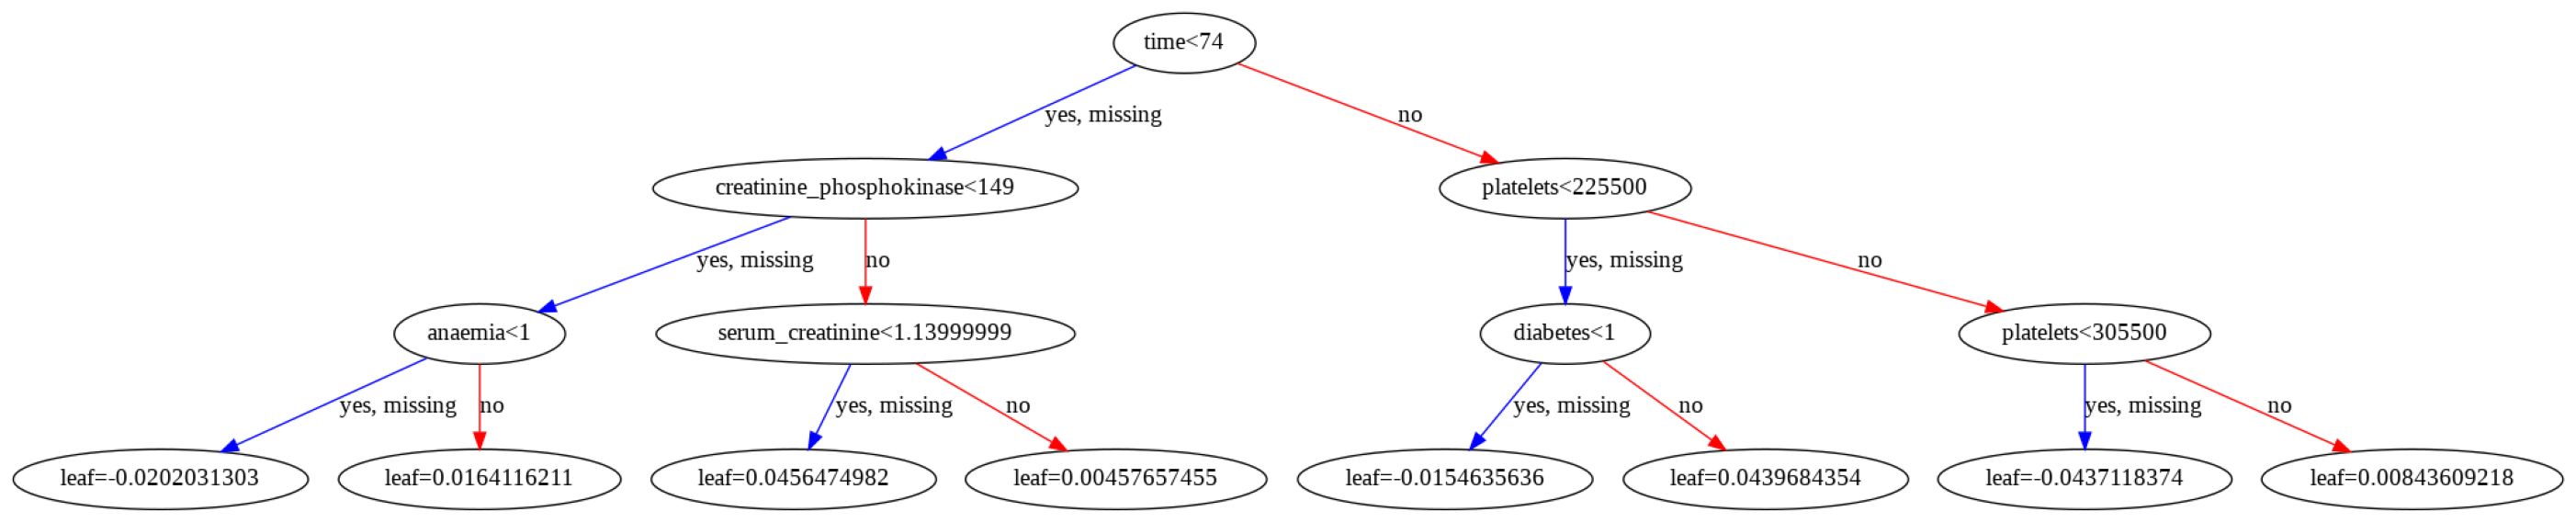

In [ ]:
plot_tree(model,num_trees=95)
fig = plt.gcf()
fig.set_size_inches(50, 150)
plt.savefig('XGBoost.jpg')
plt.show()

### Grid search to find the best hyperparameter for XGBoost

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4, 5,6,7,8,9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4,5,6,7,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
model = xgb.XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
xgb_random.fit(x_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.4s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_dept

In [ ]:
xgb_random.best_params_

{'bootstrap': False,
 'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 118}

In [ ]:
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True )
model =  xgb.XGBClassifier(bootstrap=False,max_depth=1,max_features='sqrt',min_samples_leaf=2, min_samples_spilt=7, n_estimators=118)
 
result_xgb = cross_validate(model , X_new, y, cv = kf, scoring=scoring)
 
result_xgb = pd.DataFrame(result_xgb)
result_xgb = result_xgb.append(result_xgb.mean(), ignore_index=True)
result_xgb

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,0.031950,0.004036,0.766667,0.857143,0.500000,0.631579
1,0.021425,0.003656,0.800000,0.888889,0.615385,0.727273
2,0.022507,0.003592,0.866667,0.900000,0.750000,0.818182
3,0.022770,0.005611,0.866667,1.000000,0.692308,0.818182
4,0.026011,0.003611,0.833333,0.500000,0.800000,0.615385
5,0.024346,0.003738,0.966667,1.000000,0.888889,0.941176
6,0.021768,0.003463,0.933333,1.000000,0.750000,0.857143
7,0.022074,0.005364,0.833333,0.625000,0.714286,0.666667
8,0.024264,0.004322,0.800000,0.800000,0.666667,0.727273
9,0.020489,0.004735,0.931034,0.714286,1.000000,0.833333


In [ ]:
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
              max_features='sqrt', min_child_weight=1, min_samples_leaf=2,
              min_samples_spilt=7, missing=None, n_estimators=118, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#Visualizing 

Feature: 0, Score: 0.07654
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.07311
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.11528
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.04833
Feature: 7, Score: 0.20089
Feature: 8, Score: 0.06177
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.42407


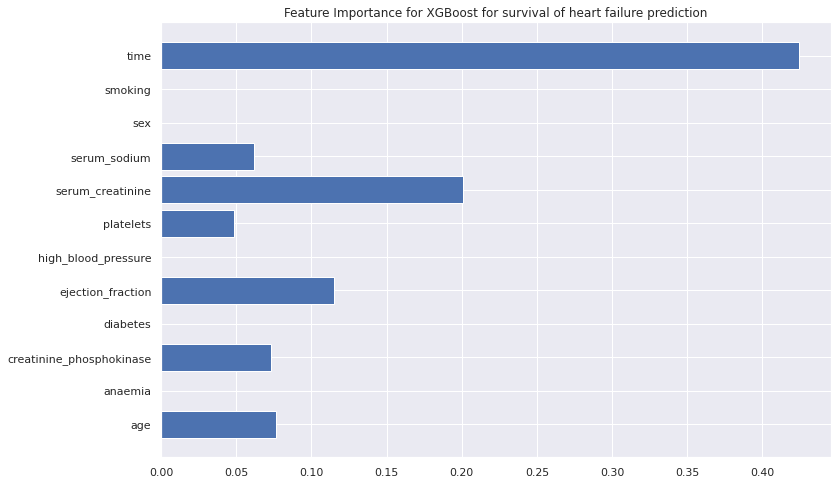

In [ ]:
importance_xgb = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_xgb):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in X.columns], importance_xgb)
plt.title('Feature Importance for XGBoost for survival of heart failure prediction')
plt.show()

In [ ]:
from sklearn.inspection import partial_dependence
def plot_pdp(model, X, feature, target=False, return_pd=False, y_pct=True, figsize=(10,9), norm_hist=True, dec=.5):
    # Get partial dependence
    pardep = partial_dependence(model, X, [feature])
    
    # Get min & max values
    xmin = pardep[1][0].min()
    xmax = pardep[1][0].max()
    ymin = pardep[0][0].min()
    ymax = pardep[0][0].max()
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.grid(alpha=.5, linewidth=1)
    
    # Plot partial dependence
    color = 'tab:blue'
    ax1.plot(pardep[1][0], pardep[0][0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel(feature, fontsize=14)
    
    tar_ylabel = ': {}'.format(target) if target else ''
    ax1.set_ylabel('Partial Dependence{}'.format(tar_ylabel), color=color, fontsize=14)
    
    tar_title = target if target else 'Target Variable'
    ax1.set_title('Relationship Between {} and {}'.format(feature, tar_title), fontsize=16)
    
    if y_pct and ymin>=0 and ymax<=1:
        # Display yticks on ax1 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax1.get_yticklabels()]
        labels = [int(np.float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax1.set_yticklabels(labels)
    
    # Plot line for decision boundary
    ax1.hlines(dec, xmin=xmin, xmax=xmax, color='black', linewidth=2, linestyle='--', label='Decision Boundary')
    ax1.legend()

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.hist(X[feature], bins=80, range=(xmin, xmax), alpha=.25, color=color, density=norm_hist)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Distribution', color=color, fontsize=14)
    
    if y_pct and norm_hist:
        # Display yticks on ax2 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        labels = [int(np.float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax2.set_yticklabels(labels)

    plt.show()
    
    if return_pd:
        return pardep

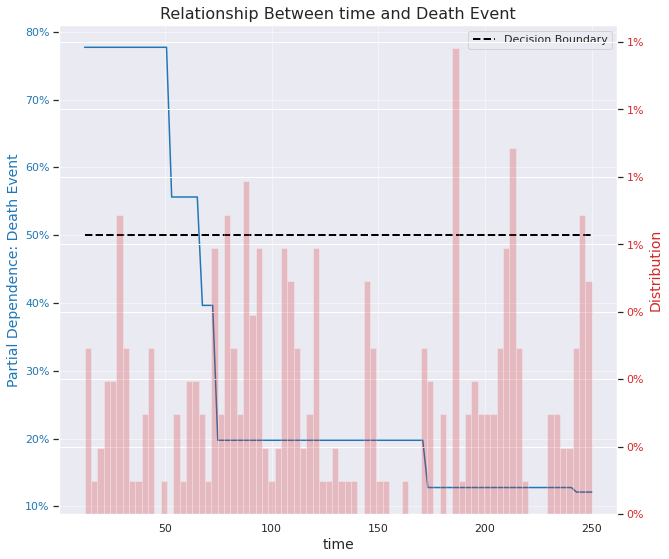

In [ ]:
plot_pdp(model,X,'time',target='Death Event')

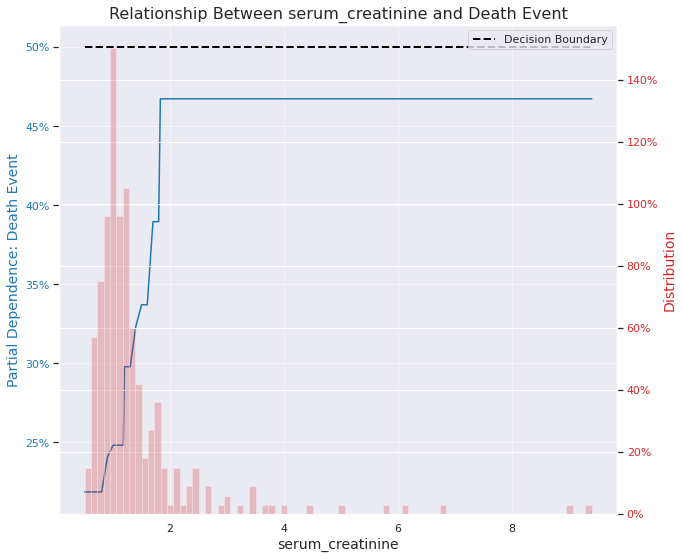

In [ ]:
plot_pdp(model, X, 'serum_creatinine',target='Death Event') 

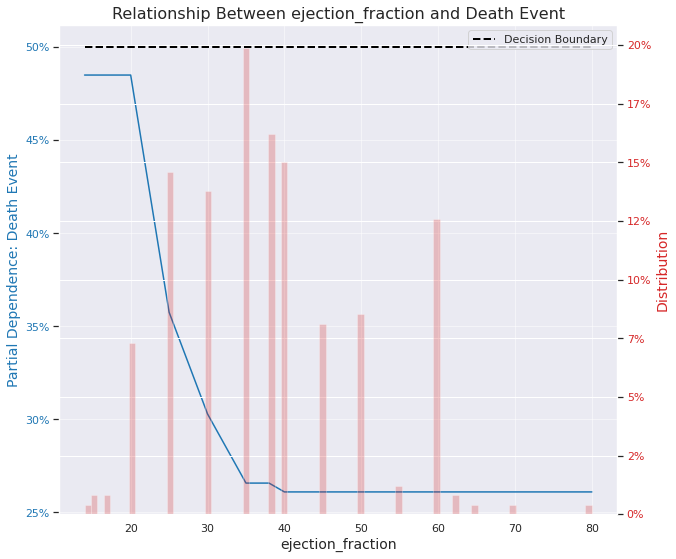

In [ ]:
plot_pdp(model, X,'ejection_fraction',target='Death Event') 

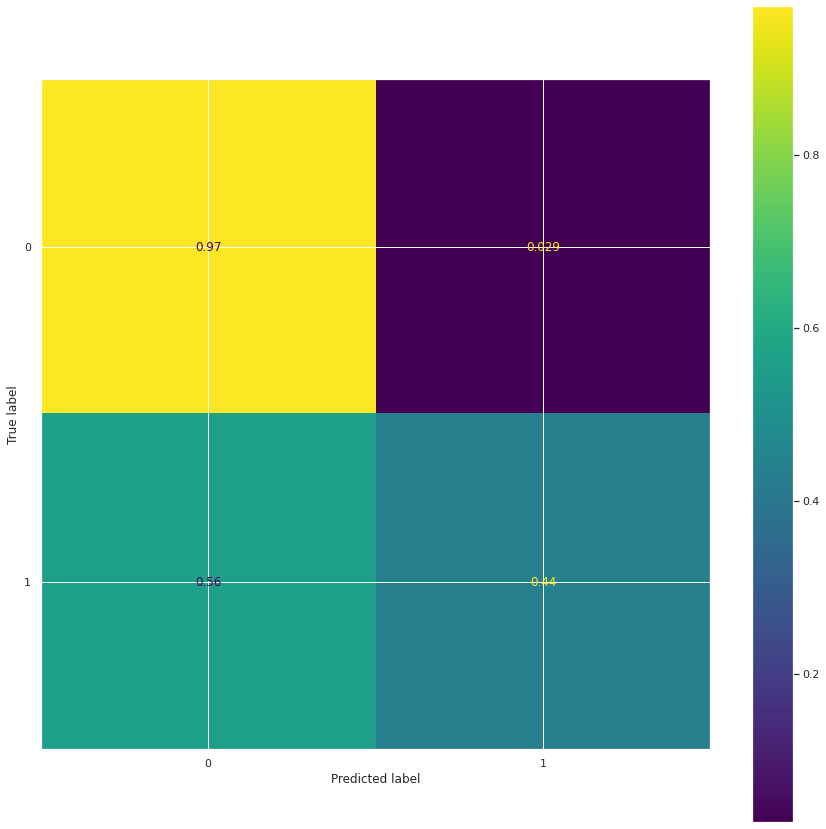

In [ ]:
fig2 = plt.figure(figsize=(15, 15))
# Create an axes instance
ax = fig2.add_subplot(111)
plot_confusion_matrix(model, x_test, y_test,ax=ax, normalize = 'true')  

plt.show()  

In [ ]:
X.to_csv('cleaned_data_heart_features.csv')
y.to_csv('label.csv')
x_train.to_csv('x_train.csv')
y_train.to_csv('y_train.csv')
x_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')